In [10]:
# Import packages - may take a few seconds to load everything in
using Revise
using HistoryStacks
using OrdinaryDiffEq
using RecursiveArrayTools
using ForwardDiff
using Plots
default(grid=false,framestyle=:box,fontfamily="Computer Modern",label="",lw=2,palette=:tab10,labelfontsize=16, tickfontsize=12,legendfontsize=12,legend_background_color=nothing,legend_foreground_color=nothing)

In [11]:
# Damped inverted pendulum dynamics
f(x) = [x[2], 0.0]
F(x) = [0.0 0.0 0.0; -sin(x[1]) -x[2] -x[2]^2]
g(x) = [0.0, 1.0]
θ = [1.0, 0.2, 0.1]
f(x, u) = f(x) + F(x)*θ + g(x)*u

f (generic function with 2 methods)

In [12]:
# Build control Lyapunov function
V(x) = (x[2] + x[1])^2 + x[1]^2
∇V(x) = ForwardDiff.gradient(V, x)
LfV(x) = ∇V(x)'f(x)
LFV(x) = ∇V(x)'F(x)
LgV(x) = ∇V(x)'g(x)

LgV (generic function with 1 method)

In [13]:
# Pointwise min-norm controller
α = 1.0
ψ(x, θ̂) = LfV(x) + LFV(x)*θ̂ + α*V(x)
kCLF(x, θ̂) = ψ(x, θ̂) <= 0.0 ? 0.0 : -ψ(x,θ̂)*LgV(x)'/(LgV(x)*LgV(x)')

kCLF (generic function with 1 method)

In [14]:
# Build odefuncion
function odefun(dy, y, p, t)
    # Unpack states
    x = y.x[1]
    θ̂ = y.x[2]

    # Unpack parameters
    Γ, H, γc = p["Γ"], p["H"], p["γ"]

    # Assign vector fields
    dy.x[1] .= f(x, kCLF(x,θ̂))
    dy.x[2] .= Γ*(LFV(x)' + γc*HistoryStacks.gradient_vector_field(H, θ̂))
end

odefun (generic function with 1 method)

In [15]:
# Define callback function for updating history stack

dt = 0.1 # How often we want to update stack
T = 20.0 # Length of sim
tstops = 0.0:dt:T # Stopping times

# Condition for stopping integrator
condition(u,t,integrator) = t ∈ tstops 

# Modify history stack when integration is stopped
function affect!(integrator)
    # Get states
    x = integrator.u.x[1]
    θ̂ = integrator.u.x[2]

    # Compute control
    u = kCLF(x,θ̂)

    # Get regressor and target
    regressor = F(x)
    target = f(x, u) - f(x) - g(x)*u # Add noise here if desired

    # Update stack
    update!(integrator.p["H"], regressor, target)

    return integrator
end

# Create callback
cb = DiscreteCallback(condition, affect!)

DiscreteCallback{…}(condition, affect!, SciMLBase.INITIALIZE_DEFAULT, SciMLBase.FINALIZE_DEFAULT, Bool[1, 1])

In [16]:
# Initial conditions
x0 = [-1.0, 0.0]
θ̂0 = rand(3)
y0 = ArrayPartition(x0, θ̂0)

# Learning gains
Γ = 1.0 # CLF learning gain
γc = 8.0 # History stack learning gain

# Setup history stack
M = 20      
δ = 0.1
H = HistoryStack(M, δ)

# Define parameter dictionary
p = Dict(
    "Γ" => Γ,
    "H" => H,
    "γ" => γc,
)

# Solve
prob = ODEProblem(odefun, y0, (0,T), p)
sol = solve(prob, Tsit5(), callback=cb, tstops=tstops);

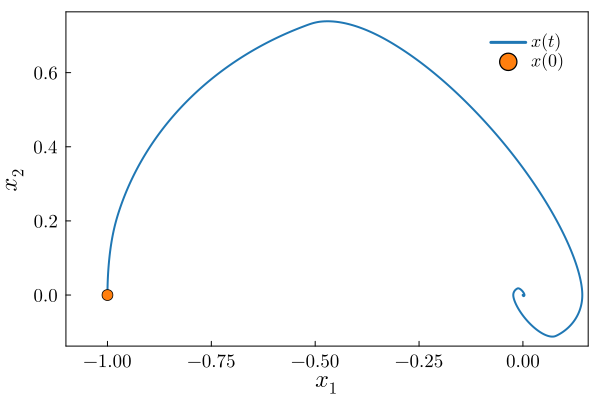

In [17]:
# Plot system trajectory
plot(sol, idxs=(1,2), xlabel=raw"$x_1$", ylabel=raw"$x_2$", label=raw"$x(t)$")
scatter!([x0[1]], [x0[2]], label=raw"$x(0)$", ms=6)

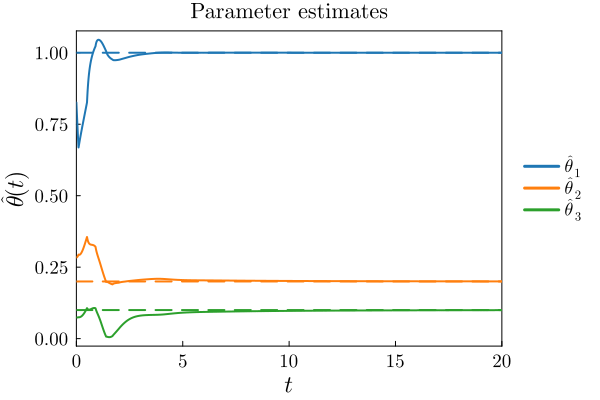

In [18]:
# Plot parameter estimates
plot(sol, idxs=3:5, xlabel=raw"$t$", ylabel=raw"$\hat{\theta}(t)$", label=[raw"$\hat{\theta}_1$" raw"$\hat{\theta}_2$" raw"$\hat{\theta}_3$"], title="Parameter estimates", legend_position=:outerright)
hline!([θ[1]], ls=:dash, c=1)
hline!([θ[2]], ls=:dash, c=2)
hline!([θ[3]], ls=:dash, c=3)